<a href="https://colab.research.google.com/github/rahulrajpr/milestone_projects/blob/main/nlp_skimlit_text_abstract/skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective : Skimming Medical Papers - Abstracting The Medical Paper with Sentance Classification

Paper to Bench mark : https://arxiv.org/abs/1612.05251

DataSet : https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d51db254-0ec8-137d-1597-f8484f65d589)


> Lets get and import the helper functioons

In [3]:
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py

--2023-03-07 11:43:06--  https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11994 (12K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  11.71K  --.-KB/s    in 0s      

2023-03-07 11:43:06 (114 MB/s) - ‘helper_functions.py’ saved [11994/11994]



In [4]:
from helper_functions import unzip_data

# Get the dataset

DataSource : https://github.com/Franck-Dernoncourt/pubmed-rct

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct # cloning entire the dataset from github.com 

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.23 MiB/s, done.
Updating files: 100% (13/13), done.


In [6]:
!ls -lh

total 24K
-rw-r--r-- 1 root root  12K Mar  7 11:43 helper_functions.py
drwxr-xr-x 7 root root 4.0K Mar  7 11:43 pubmed-rct
drwxr-xr-x 2 root root 4.0K Mar  7 11:43 __pycache__
drwxr-xr-x 1 root root 4.0K Mar  3 14:33 sample_data


In [7]:
!ls pubmed-rct/

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Note : There are four versions of the dataset

1. full version - 200K items with numbers included
2. full version - 200K items with numbers replaced with @

3. small version - 20K items with numbers included
4. small version - 20K items with numbers replaced with @

> We choose the small version in begining with numbers replaced with @

In [8]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [9]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign -lh

total 37M
-rw-r--r-- 1 root root 4.7M Mar  7 11:43 dev.txt
-rw-r--r-- 1 root root 4.6M Mar  7 11:43 test.txt
-rw-r--r-- 1 root root  28M Mar  7 11:43 train.txt


since the train, val, test datasets are in text format as shown below, we need to define a function get the deta of the text file so that it can be fed into a model

here is how the data looks like in the text file

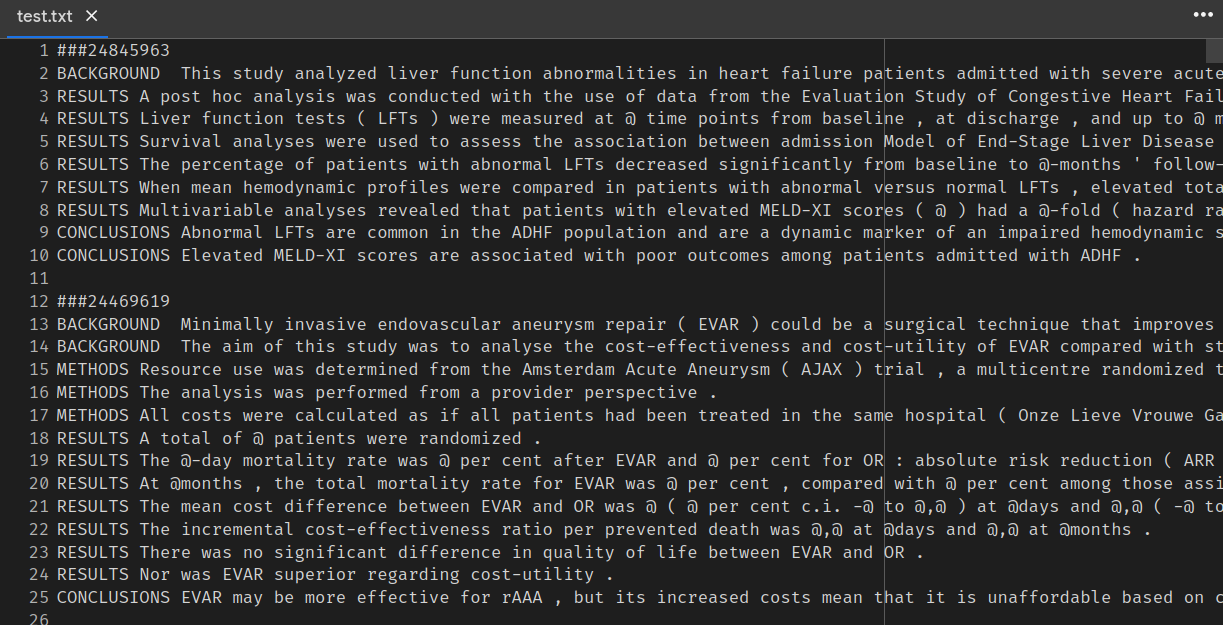

lets read in the data using the open menthod in python

In [10]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

train_dir = data_dir + 'train.txt'

val_dir = data_dir + 'dev.txt'

test_dir = data_dir + 'test.txt'

In [11]:
def read_txt_lines(filepath):

  """ function which returns the line of the text file"""

  with open(filepath, 'r') as f:
    return f.readlines()

In [12]:
train_lines = read_txt_lines(train_dir)

train_lines[:25]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Inference : 

1. Inforrmation about a paper starts with '###"
2. Information about a paper ends with '\n'
3. Abstract line containes label and sentance in the order seperated by '\t'

Note from the text file, we want extract the following things,

1. abstract index number
2. abstract label
3. abstract context(text)
4. total numeber of abstract in the paper

> Lets define a functiuon that extract all the aboev information a create a list of dictionaries

In [13]:
def extract_data_from_text_file(filepath):

  """ takes the text filepath and return the list of dictories of each abstracts for each paper of the contained in the text file"""

  abstracts, all_data = [],[]

  input_lines = read_txt_lines(filepath) # reading the input lines

  for line in input_lines:

    if line.startswith('###'): # if initial line of a paper (comes fist for a paper)
      abstract_id = line.strip('\n')
      
    elif line.isspace(): # if endinf line of a peper (comes last for a paper)
      for ind,abstract in enumerate(abstracts):

        label,text = abstract.split('\t')
        text = text.strip('\n').strip('\t').strip(' ').lower()
        
        data_dict = {'id':abstract_id,
                     'line_number':ind,
                     'label':label,
                     'text':text,
                     'total_lines': len(abstracts)}

        all_data.append(data_dict)
      abstracts = [] # reset the abstracts variable to store the data for the new paper

    else: # if astract line
      abstracts.append(line) # storing each abstract in order for paper and get reset while it passes through the newline look above

  return all_data # retuns the list of dictonatoies for each absstract in the text file

In [14]:
# passing the respective data dirs through the above function a create the dataset ready

train_data = extract_data_from_text_file(train_dir)
val_data = extract_data_from_text_file(val_dir)
test_data = extract_data_from_text_file(test_dir)

In [15]:
train_data[:15]

[{'id': '###24293578',
  'line_number': 0,
  'label': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 12},
 {'id': '###24293578',
  'line_number': 1,
  'label': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 12},
 {'id': '###24293578',
  'line_number': 2,
  'label': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 12},
 {'id': '###24293578',
  'line_number': 3,
  'label': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 12},


In [16]:
# printing the length of train, validation, test datasets

len(train_data),len(val_data),len(test_data)

(180040, 30212, 30135)

In [17]:
# turning the datasets into dataframes

train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

In [18]:
train_df['label'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: label, dtype: int64

In [19]:
train_df['label'].value_counts(normalize = True)

METHODS        0.329666
RESULTS        0.321890
CONCLUSIONS    0.150900
BACKGROUND     0.120679
OBJECTIVE      0.076866
Name: label, dtype: float64

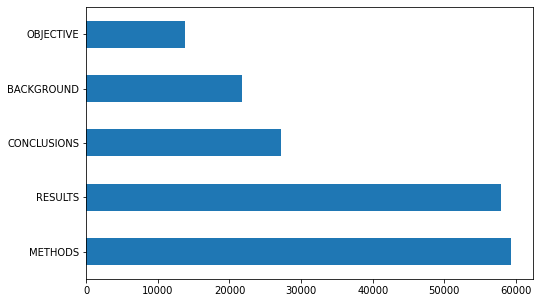

In [20]:
# plot the distribution of the different labels

train_df['label'].value_counts().plot(kind = 'barh', figsize = (8,5));

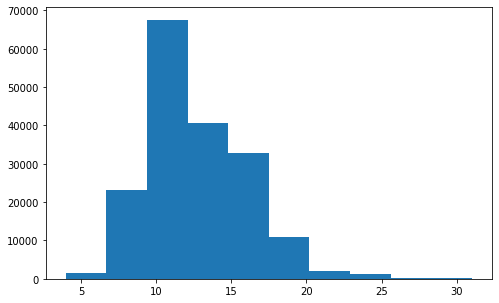

In [21]:
# lets plot the distribution of total number of lines

plt.figure(figsize = (8,5))
plt.hist(train_df['total_lines']);

> Getting the sentances varibale across all the datasets

In [22]:
train_sentances = train_df['text'].to_numpy()
val_sentances = val_df['text'].to_numpy()
test_sentances = test_df['text'].to_numpy()

train_sentances[:10]

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
       'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
       'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) we

> Getting the labels varibale across all the datasets

In [23]:
train_target = train_df['label'].to_numpy()
val_target = val_df['label'].to_numpy()
test_target = test_df['label'].to_numpy()
train_target[:10]

array(['OBJECTIVE', 'METHODS', 'METHODS', 'METHODS', 'METHODS', 'METHODS',
       'RESULTS', 'RESULTS', 'RESULTS', 'RESULTS'], dtype=object)

In [24]:
train_target.reshape(-1,1)

array([['OBJECTIVE'],
       ['METHODS'],
       ['METHODS'],
       ...,
       ['RESULTS'],
       ['CONCLUSIONS'],
       ['CONCLUSIONS']], dtype=object)

> Encode the labels

1. OneHot Encoding
2. Label Encoding

In [25]:
# OneHot Encoding 

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False)

train_target_onehot_encoded = one_hot_encoder.fit_transform(train_target.reshape(-1,1))
val_target_onehot_encoded = one_hot_encoder.transform(val_target.reshape(-1,1))
test_target_onehot_encoded = one_hot_encoder.transform(test_target.reshape(-1,1))

train_target_onehot_encoded[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [26]:
one_hot_encoder.categories_

[array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object)]

In [27]:
# Label Encoding

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_target_label_encoded = label_encoder.fit_transform(train_target)
val_target_label_encoded = label_encoder.transform(val_target)
test_target_label_encoded = label_encoder.transform(test_target)

train_target_label_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [28]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

Model we are going to try : 

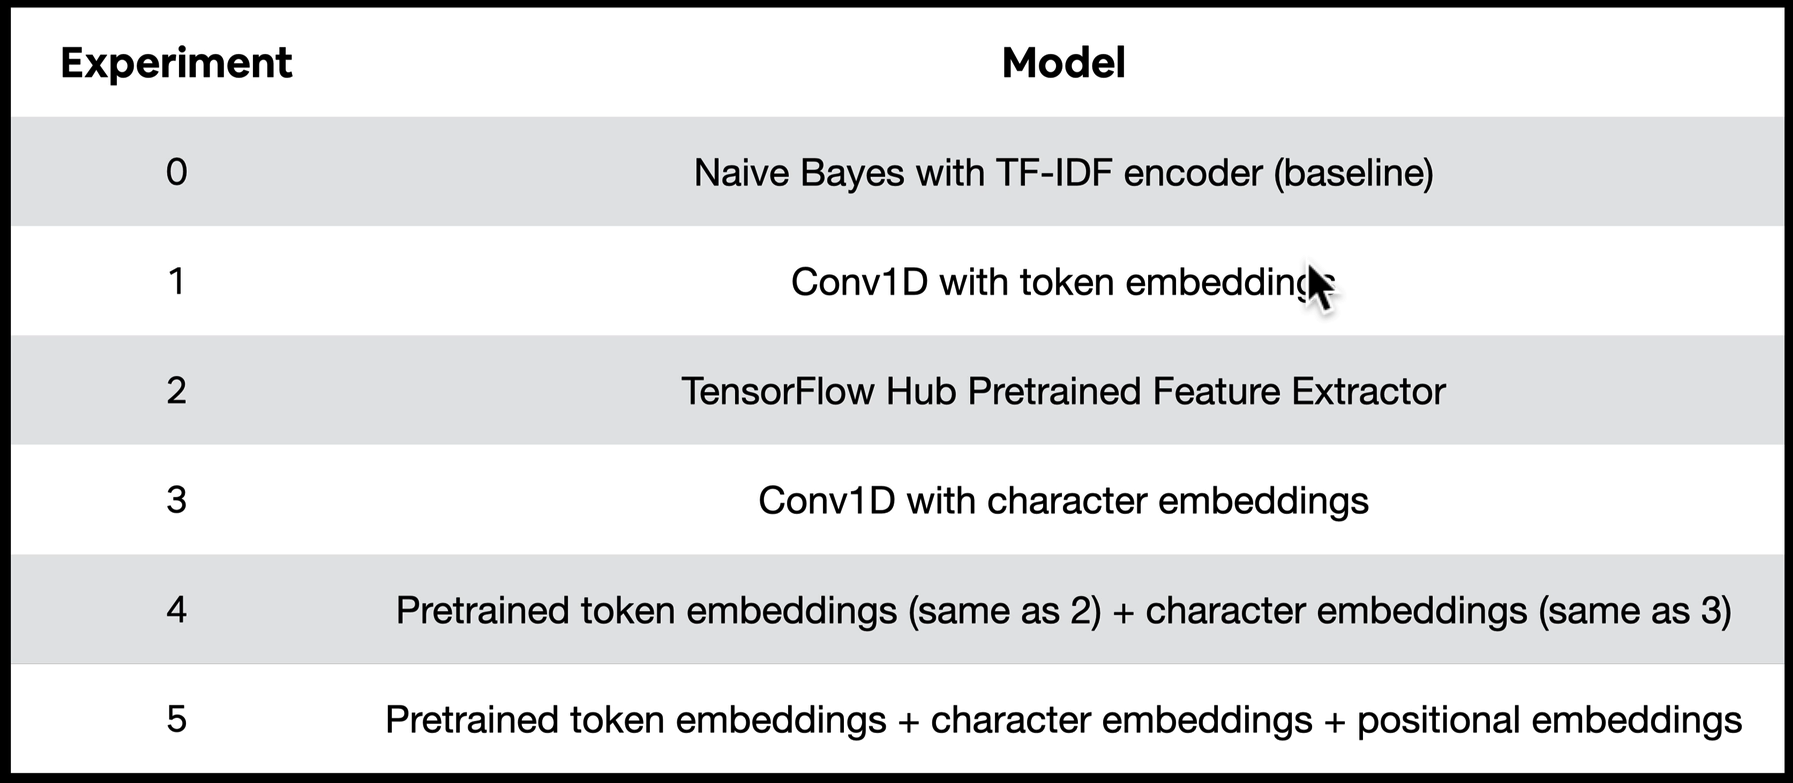

# Model 0 (BaseLine Model): Naive Bayse with TF-IDF encoder

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [30]:
model_0 = Pipeline([('tfidf_vectorization',TfidfVectorizer()),
                    ('clf',MultinomialNB())])

model_0.fit(X = train_sentances,
            y = train_target_label_encoded)

Pipeline(steps=[('tfidf_vectorization', TfidfVectorizer()),
                ('clf', MultinomialNB())])

In [31]:
model_0.score(val_sentances, val_target_label_encoded)

0.7218323844829869

In [32]:
pred_0 = model_0.predict(val_sentances)
pred_0[:10]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4])

In [33]:
from helper_functions import calculate_results

In [34]:
result_0 = calculate_results(y_true = val_target_label_encoded,
                            y_pred = pred_0)

result_0

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Prepare our text data for deep leaning 

- > Tokenization
- > Embedding 

For that we need to arrive the following information

- define the number of maximum tokens in a sentance
- define the number of unique tokens in the whole input


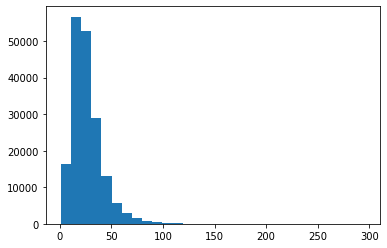

In [35]:
list_token_len = [len(x.split()) for x in train_sentances]
plt.hist(list_token_len,bins = 30);

In [36]:
mean_token_len = round(np.mean(list_token_len))
max_token_len = round(np.max(list_token_len))

mean_token_len,max_token_len

(26, 296)

In [37]:
# lets take the optimum token len as the 95th percentile

opt_token_len = int(np.percentile(list_token_len,95))
opt_token_len

55

Lets find out the number of unique tokens in the train dataset.

As pee the peper, there are 68K of unique tokens(words) in the 20K version of the dataset

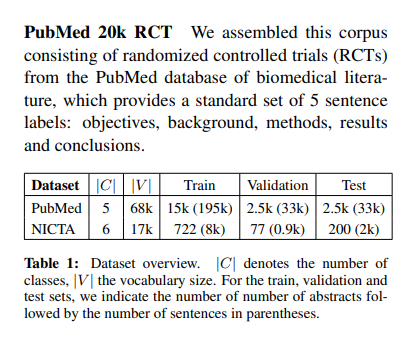

In [38]:
unique_token_count = 68000

> Lets create the optimization Layer

In [39]:
from tensorflow.keras import layers

In [40]:
text_vectorizer = layers.TextVectorization(max_tokens = unique_token_count, # number of words in the vocabulary
                                          output_sequence_length = opt_token_len, name = 'text_vectorizer') # numbers of tokens required in the output sequence

In [41]:
text_vectorizer.adapt(train_sentances) # trained on the train sentances

In [42]:
text_vectorizer.get_config()

{'name': 'text_vectorizer',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

In [43]:
list_vocabulary = text_vectorizer.get_vocabulary()
list_vocabulary[:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

In [44]:
print(f'Top10 vocabulary \n{list_vocabulary[:10]}')
print(f'Bottom10 vocabulary \n{list_vocabulary[-10:]}')

Top10 vocabulary 
['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Bottom10 vocabulary 
['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


> Lets create the embedding layer

In [45]:
embed_layer = layers.Embedding(input_dim = unique_token_count,
                               output_dim = 128,
                               mask_zero = True,
                               name = 'embedding_layer')

> Lets try to pass the one of the random sample through the text vectorizer and embedding layter see the outputs.

In [46]:
random_sentance = random.choice(train_sentances)
random_sentance_vectorized = text_vectorizer([random_sentance])
random_sentance_embedded = embed_layer(random_sentance_vectorized)
print(f'Random Sentance : {random_sentance}\n')
print(f'sentance vectorized -- shape : {random_sentance_vectorized.shape}\n\n{random_sentance_vectorized}\n')
print(f'sentance Embedded : -- shape : {random_sentance_embedded.shape}\n\n{random_sentance_embedded[:10]}')

Random Sentance : to evaluate the efficacy and safety of treatment with auriculopressure applied to patients with non-specific spinal pain .

sentance vectorized -- shape : (1, 55)

[[    6   164     2    79     3   136     4    19     7 27387   551     6
     12     7  3596   841    65     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

sentance Embedded : -- shape : (1, 55, 128)

[[[ 0.01050738  0.01600586  0.04435406 ... -0.01575886 -0.00515289
    0.03313744]
  [ 0.04392372  0.04861189 -0.02889614 ...  0.04621435 -0.01116097
   -0.02530278]
  [-0.02216147 -0.03655906 -0.03415517 ...  0.00340711 -0.02192401
    0.01415941]
  ...
  [-0.02266723  0.03319849  0.02820123 ...  0.01922696 -0.04253573
   -0.02851968]
  [-0.02266723  0.03319849  0.02820123 ...  0.01922696 -0.04253573
   -0.02851968]
  [-0.022

# Convert the dataset into tf.data.Dataset format to load it faster

1. conveting into a tf.dataset format
2. convert them into batched with AUTOTUNE enabled

In [47]:
# convert into a tf.dataset format

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentances,train_target_onehot_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentances,test_target_onehot_encoded))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentances,val_target_onehot_encoded))

In [48]:
# convert them into batches

BS = 32

train_dataset = train_dataset.batch(BS).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BS).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BS).prefetch(tf.data.AUTOTUNE)

In [49]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Lets Build the Model 1 - Conv1D

In [50]:
num_classes = len(label_encoder.classes_)
num_classes

5

In [51]:
from tensorflow.keras.optimizers import Adam

In [52]:
# build the conv1D Model

inputs = tf.keras.Input(shape = (1,), dtype = tf.string, name = 'input_layer')

vectorizer = text_vectorizer(inputs)

embedder = embed_layer(vectorizer)

x = layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu', name = 'conv1_layer')(embedder)

x = layers.GlobalAveragePooling1D(name = 'global_avg_pooling')(x)

outputs = layers.Dense(units = num_classes, activation = 'softmax', name = 'output_layer')(x)

model_1 = tf.keras.Model(inputs,outputs, name = 'model_1')

# compile model

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

In [53]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorizer (TextVector  (None, 55)               0         
 ization)                                                        
                                                                 
 embedding_layer (Embedding)  (None, 55, 128)          8704000   
                                                                 
 conv1_layer (Conv1D)        (None, 55, 64)            41024     
                                                                 
 global_avg_pooling (GlobalA  (None, 64)               0         
 veragePooling1D)                                                
                                                                 
 output_layer (Dense)        (None, 5)                 325 

> Lets train the conv1D model

In [54]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [55]:
# see the number of batches

len(train_dataset)

5627

In [56]:
len(train_dataset)*BS

180064

The amout of datapoint from experimienting is still higher even after we have chossen the 20K dataset. lets take 10% of the steps in the training and evalutaion phase in the model training 

In [57]:
# lets train the model

history_1 = model_1.fit(train_dataset,
                        epochs = 5,
                        steps_per_epoch = int(0.1*len(train_dataset)),
                        validation_data = val_dataset,
                        validation_steps = int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 50s 66ms/step - loss: 0.9232 - accuracy: 0.6370 - val_loss: 0.6879 - val_accuracy: 0.7360
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.6587 - accuracy: 0.7563 - val_loss: 0.6287 - val_accuracy: 0.7726
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6182 - accuracy: 0.7741 - val_loss: 0.5972 - val_accuracy: 0.7826
Epoch 4/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5905 - accuracy: 0.7865 - val_loss: 0.5786 - val_accuracy: 0.7872
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5924 - accuracy: 0.7912 - val_loss: 0.5633 - val_accuracy: 0.7949


In [58]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5629 - accuracy: 0.8003


[0.5629499554634094, 0.8003111481666565]

In [59]:
pred_1_probs = model_1.predict(val_sentances)
pred_1_probs

945/945 [==============================] - 3s 3ms/step


array([[5.1594949e-01, 2.1537663e-01, 4.6760570e-02, 1.7302589e-01,
        4.8887353e-02],
       [4.2713708e-01, 3.5685548e-01, 2.7159184e-02, 1.4208554e-01,
        4.6762682e-02],
       [1.7030518e-01, 3.3279050e-03, 1.1986274e-03, 8.2511181e-01,
        5.6462690e-05],
       ...,
       [2.7285176e-05, 6.1006041e-04, 3.9166058e-03, 2.2106367e-05,
        9.9542397e-01],
       [8.7795600e-02, 3.3358017e-01, 1.5602653e-01, 7.3770449e-02,
        3.4882733e-01],
       [1.6309677e-01, 7.5528407e-01, 5.1230364e-02, 9.2430227e-03,
        2.1145826e-02]], dtype=float32)

In [60]:
pred_1 = np.argmax(pred_1_probs, axis = 1)
pred_1

array([0, 0, 3, ..., 4, 4, 1])

> Lets calculate the results of the model_1

In [61]:
result_1 = calculate_results(y_true = val_target_label_encoded,
                             y_pred = pred_1)

result_1

{'accuracy': 0.800311134648484,
 'precision': 0.8011425224021341,
 'recall': 0.800311134648484,
 'f1': 0.797210708909592}

In [62]:
result_0

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1 : Feature Extraction with pre-trained Model from Tensorflow hub - USE

USE - Universal Sentance Encoder : https://tfhub.dev/google/universal-sentence-encoder/4

Tensorflow hob description :  The input is variable length English text and the output is a 512 dimensional vector.

In [63]:
# lets create the feature extraction layer : 

import tensorflow_hub as hub

use_layer = hub.KerasLayer(handle = 'https://tfhub.dev/google/universal-sentence-encoder/4',
                           trainable = False)

In [64]:
# lets check some randaom sentance output.

random_sentance = random.choice(train_sentances)

use_output = use_layer([random_sentance])

use_output[:3], use_output.shape

(<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
 array([[-6.57183975e-02,  4.30380777e-02, -3.40453573e-02,
         -6.35006130e-02, -2.49485988e-02,  2.00170185e-02,
         -2.56983787e-02, -4.85928878e-02,  9.32221953e-03,
          1.87731348e-02,  8.23072046e-02, -5.56930751e-02,
         -3.37230340e-02,  3.92690375e-02,  6.19986057e-02,
         -7.26207867e-02, -8.28053430e-02,  1.57977175e-02,
         -1.85555220e-02,  5.58765270e-02, -5.08167967e-02,
          4.62533087e-02,  3.09461113e-02, -2.40914500e-03,
          4.07727063e-02,  4.23773937e-02, -5.75610101e-02,
         -7.92296417e-03,  2.74745692e-02,  3.55745442e-02,
          4.11614776e-02,  8.27591270e-02, -3.35783921e-02,
         -6.85801357e-02, -3.87196578e-02, -3.11249141e-02,
          3.67172435e-02,  6.78775553e-03, -6.03439510e-02,
         -5.12747206e-02,  7.94299245e-02, -1.71675403e-02,
          4.88207042e-02, -4.61559519e-02,  5.22943959e-02,
         -1.94153972e-02, -1.45803448e-02, -6.088

In [65]:
# lets create the model

inputs = tf.keras.Input(shape = [], dtype = tf.string, name = 'input_layer')

use_output = use_layer(inputs) 

x = layers.Dense(units = 128, activation = 'relu', name = 'dense_layer')(use_output)

outputs = layers.Dense(units = num_classes, activation = 'softmax', name = 'output_layer')(x)

model_2 = tf.keras.Model(inputs,outputs, name = 'model_2')

# compile model

model_2.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [66]:
# fit the model

history_2 = model_2.fit(train_dataset,
                        epochs = 5,
                        steps_per_epoch = int(0.1*len(train_dataset)),
                        validation_data = val_dataset,
                        validation_steps = int(0.1*len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 12s 13ms/step - loss: 0.9157 - accuracy: 0.6529 - val_loss: 0.7976 - val_accuracy: 0.6895
Epoch 2/5
562/562 [==============================] - 8s 15ms/step - loss: 0.7691 - accuracy: 0.7020 - val_loss: 0.7549 - val_accuracy: 0.7058
Epoch 3/5
562/562 [==============================] - 9s 15ms/step - loss: 0.7526 - accuracy: 0.7116 - val_loss: 0.7398 - val_accuracy: 0.7108
Epoch 4/5
562/562 [==============================] - 12s 22ms/step - loss: 0.7187 - accuracy: 0.7239 - val_loss: 0.7109 - val_accuracy: 0.7237
Epoch 5/5
562/562 [==============================] - 14s 25ms/step - loss: 0.7250 - accuracy: 0.7224 - val_loss: 0.6887 - val_accuracy: 0.7367


In [67]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 0.6970 - accuracy: 0.7357


[0.6969642639160156, 0.7357010245323181]

In [68]:
pred_2_prob = model_2.predict(val_dataset)
pred_2_prob[:10]

945/945 [==============================] - 15s 15ms/step


array([[6.78498089e-01, 1.97697595e-01, 2.00653286e-03, 1.12410218e-01,
        9.38756578e-03],
       [4.44185734e-01, 4.65914100e-01, 4.58116969e-03, 8.24839920e-02,
        2.83504650e-03],
       [3.96158963e-01, 6.47418052e-02, 4.51519489e-02, 4.48963284e-01,
        4.49841022e-02],
       [6.83817081e-03, 1.50863966e-02, 9.32364583e-01, 3.63573991e-03,
        4.20752279e-02],
       [9.32259392e-03, 1.01781614e-01, 5.10876954e-01, 3.84343811e-03,
        3.74175370e-01],
       [2.27309152e-04, 7.33355817e-04, 8.02883506e-01, 4.63301549e-05,
        1.96109518e-01],
       [9.03930806e-04, 2.82476633e-03, 6.54856563e-01, 7.37311784e-04,
        3.40677410e-01],
       [1.80938875e-03, 1.41593916e-02, 6.58324540e-01, 5.71218145e-04,
        3.25135440e-01],
       [5.31156431e-04, 4.36599553e-03, 2.44652480e-02, 7.61922449e-04,
        9.69875693e-01],
       [1.79845497e-01, 5.23014903e-01, 8.21616054e-02, 5.22137769e-02,
        1.62764221e-01]], dtype=float32)

In [69]:
pred_2 = np.argmax(pred_2_prob, axis = 1)
pred_2[:10]

array([0, 1, 3, 2, 2, 2, 2, 2, 4, 1])

In [70]:
result_2 = calculate_results(y_true = val_target_label_encoded,
                             y_pred = pred_2)
result_2

{'accuracy': 0.7357010459420098,
 'precision': 0.7320851375171501,
 'recall': 0.7357010459420098,
 'f1': 0.7298243240275767}

# Model : 3 - Conv1D with character level token embeddings 

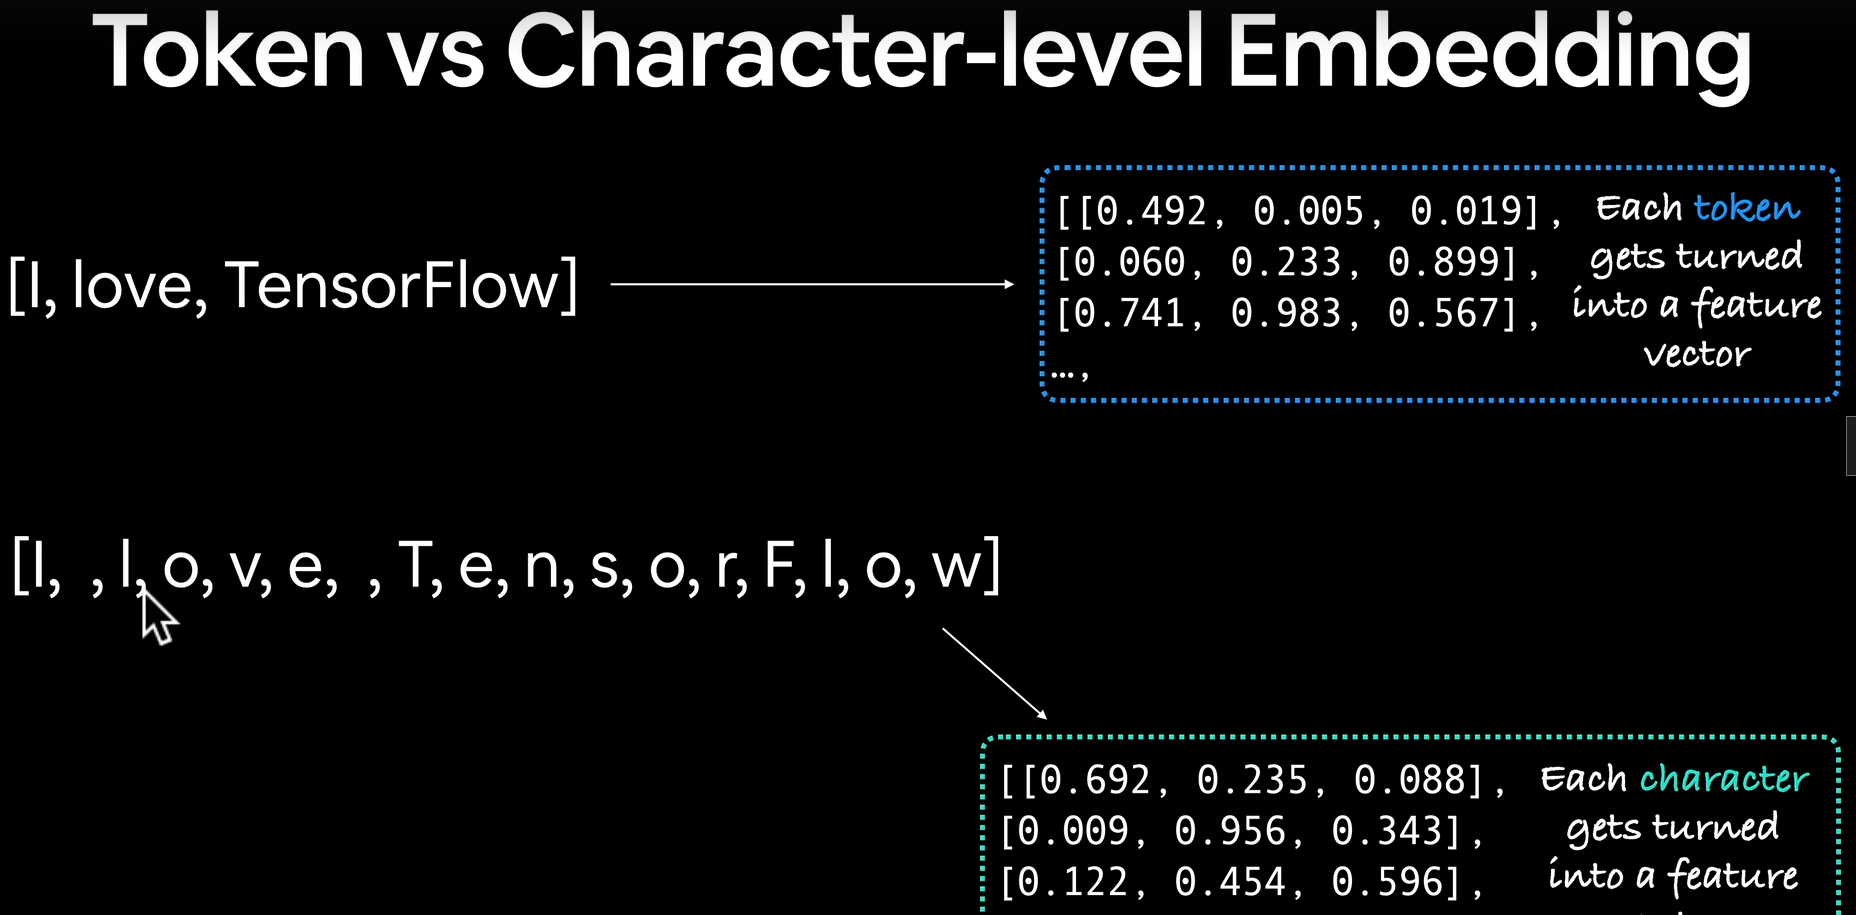

Steps :

1. create a token level dataset
2. create a vectorizer
3. create an embedding layer
4. build and compile the model using the keras fucntional API
5. create the tf.data dataset with pre-fetch for the faster dataloading
6. fit the model
7. Evaluate the model

In [71]:
# function to map the character level tokenization

def char_level_token(text):

  return " ".join(list(text))

In [72]:
# lets look at one of the train sentances

char_level_token(train_sentances[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

> Lets Map the fuction to the entire dataset

In [73]:
train_char = [char_level_token(sentance) for sentance in train_sentances]
val_char = [char_level_token(sentance) for sentance in val_sentances]
test_char = [char_level_token(sentance) for sentance in test_sentances]

train_char[:10]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

> Lets create a char level vectorizer

In [74]:
train_char_len = [len(line) for line in train_char]

In [75]:
np.max(train_char_len),np.mean(train_char_len),np.percentile(train_char_len,95)

(2771, 297.7325149966674, 579.0)

In [76]:
opt_char_len = int(np.percentile(train_char_len,95)) 
opt_char_len

579

In [77]:
import string
unique_chars = string.ascii_lowercase + string.digits + string.punctuation
unique_chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [78]:
unique_char_len = len(unique_chars) + 2 # adeed 2 for the space and the 'OOV' type or ['UNK']
unique_char_len

70

In [79]:
char_vectorizer = layers.TextVectorization(max_tokens = unique_char_len,
                                           output_sequence_length = opt_char_len,
                                           name = 'char_vectorization_layer')

In [80]:
# lets adapt to the train chars to learn the vocabulary
char_vectorizer.adapt(train_char)

In [81]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'Total Number of vocab in the char embedding : {len(char_vocab)}')
print(f'Top 5 used chars : {char_vocab[:5]}')
print(f'Bottom 5 user chars : {char_vocab[-5:]}')

Total Number of vocab in the char embedding : 28
Top 5 used chars : ['', '[UNK]', 'e', 't', 'i']
Bottom 5 user chars : ['k', 'x', 'z', 'q', 'j']


> Lets create the embedding layer

In [82]:
char_embedding = layers.Embedding(input_dim = len(char_vocab),
                                  output_dim = 25, # we have choosen 25 as per the paper
                                  mask_zero = True,
                                  name = 'char_embed')

> Lets build the model

In [83]:
inputs = tf.keras.Input(shape =(1,), dtype = tf.string, name = 'input_layer')

char_vectors = char_vectorizer(inputs)

char_embed = char_embedding(char_vectors)

x = layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu')(char_embed)

x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(units = num_classes, activation = 'softmax', name = 'output_layer')(x)

model_3 = tf.keras.Model(inputs = inputs, 
                         outputs = outputs, 
                         name = 'model_3_conv1D_char_embedding')

In [84]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 char_vectorization_layer (T  (None, 579)              0         
 extVectorization)                                               
                                                                 
 char_embed (Embedding)      (None, 579, 25)           700       
                                                                 
 conv1d (Conv1D)             (None, 579, 64)           8064      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 5

In [85]:
# lets compile the model

model_3.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

> Prepare the dataset for the fiiting

In [86]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char, train_target_onehot_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char, val_target_onehot_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_char, test_target_onehot_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

> Lets fit the model on 10% of the batches of the dataset for faster performance during the experiment phase

In [87]:
history_3 = model_3.fit(train_char_dataset,
                        epochs = 5,
                        steps_per_epoch = int(0.1*len(train_char_dataset)),
                        validation_data = val_char_dataset,
                        validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 8s 10ms/step - loss: 1.4695 - accuracy: 0.3342 - val_loss: 1.4383 - val_accuracy: 0.3830
Epoch 2/5
562/562 [==============================] - 6s 11ms/step - loss: 1.3962 - accuracy: 0.4161 - val_loss: 1.3577 - val_accuracy: 0.4372
Epoch 3/5
562/562 [==============================] - 4s 8ms/step - loss: 1.3400 - accuracy: 0.4440 - val_loss: 1.3255 - val_accuracy: 0.4451
Epoch 4/5
562/562 [==============================] - 5s 8ms/step - loss: 1.3114 - accuracy: 0.4563 - val_loss: 1.3049 - val_accuracy: 0.4545
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 1.3050 - accuracy: 0.4540 - val_loss: 1.2964 - val_accuracy: 0.4757


In [88]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 1.2968 - accuracy: 0.4687


[1.296825647354126, 0.46872103214263916]

In [89]:
pred_3_probs = model_3.predict(val_char_dataset)
pred_3_probs[:10]

945/945 [==============================] - 4s 4ms/step


array([[0.24788904, 0.21493459, 0.30343804, 0.1547332 , 0.07900515],
       [0.1423806 , 0.17768627, 0.16876608, 0.06383707, 0.4473299 ],
       [0.13602744, 0.12216705, 0.5558681 , 0.09173287, 0.09420456],
       [0.05195509, 0.06787172, 0.6866923 , 0.06896517, 0.12451571],
       [0.20992583, 0.25216728, 0.19909629, 0.15402155, 0.18478905],
       [0.12085372, 0.1147291 , 0.3965594 , 0.04116077, 0.326697  ],
       [0.16019796, 0.17515722, 0.32879645, 0.09292982, 0.24291861],
       [0.3012579 , 0.29617205, 0.10723338, 0.13179211, 0.16354457],
       [0.09770144, 0.22270578, 0.14689809, 0.17639968, 0.35629502],
       [0.13769421, 0.20930849, 0.26451156, 0.18216771, 0.20631808]],
      dtype=float32)

In [90]:
pred_3 = np.argmax(pred_3_probs, axis = 1)
pred_3[:10]

array([2, 4, 2, 2, 1, 2, 2, 0, 4, 2])

In [91]:
results_3 = calculate_results(y_true = val_target_label_encoded,
                              y_pred = pred_3)
results_3

{'accuracy': 0.4687210379981464,
 'precision': 0.42083445572412864,
 'recall': 0.4687210379981464,
 'f1': 0.42097904250881635}

# Model 4 : Combining the PreTrained Token Lavel Embedding and Charactor Level Embedding using Hybrid Embedding Layer

Steps : 

1. create a token level embedding model using the hub - USE
2. create a charator level embedding model - Using the bi-LSTM
3. combine both the model using `layers.Concatenate`
4. Add a dropout layer to regularize ( or to controll overfitting )
5. build some outputs on top of the concatnate layer
6. create the final model which can take the input from the token lavel embedding and charactor level embedding
7. prepare the datainput for thr diffenrent model using the tf.data Dataset module 

In [92]:
token_use_embedding = hub.KerasLayer(handle = 'https://tfhub.dev/google/universal-sentence-encoder/4',
                                     trainable = False, 
                                     name = 'universal_sentance_encoder_layer')

In [93]:
# lets build the token embedding model

token_inputs = tf.keras.Input(shape = [], dtype = tf.string, name = 'token_inputs')
use_embed = token_use_embedding(token_inputs)
token_outputs = layers.Dense(units = 128, activation = 'relu', name = 'token_output_layer')(use_embed)
token_model = tf.keras.Model(inputs = token_inputs, 
                             outputs = token_outputs, 
                             name = 'token_model')


# lets build the charctor embedding model

char_inputs = tf.keras.Input(shape =(1,), dtype = tf.string, name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vectors)
lstm_layer = layers.Bidirectional(layers.LSTM(units = 24),name = 'bidirectional_LSTM')(char_embed)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = lstm_layer,
                            name = 'char_model')

# Combing both of the models defined above 

token_char_concat = layers.Concatenate(name = 'concat_layer')([token_model.output, char_model.output])

# Adding the dropout layers and dense layers to the combine layers

dropout_layer1 = layers.Dropout(0.5)(token_char_concat)

combined_dense = layers.Dense(units = 128, activation = 'relu', name = 'combined_dense')(dropout_layer1)

dropout_layer2 = layers.Dropout(0.5)(combined_dense)

final_outputs = layers.Dense(units = num_classes, activation = 'softmax', name = 'final_output')(dropout_layer2)

# build the final model

model_4 = tf.keras.Model(inputs = [token_model.inputs, char_model.input],
                         outputs = final_outputs, 
                         name = 'model_4_token_char_embedding_comboined')

In [94]:
model_4.summary()

Model: "model_4_token_char_embedding_comboined"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorization_layer (Text  (None, 579)         0           ['char_inputs[0][0]']            
 Vectorization)                                                                                   
                                                                                                  
 universal_sentance_encoder_lay  (None, 512)         25679782

> Lets plot the summary of the model

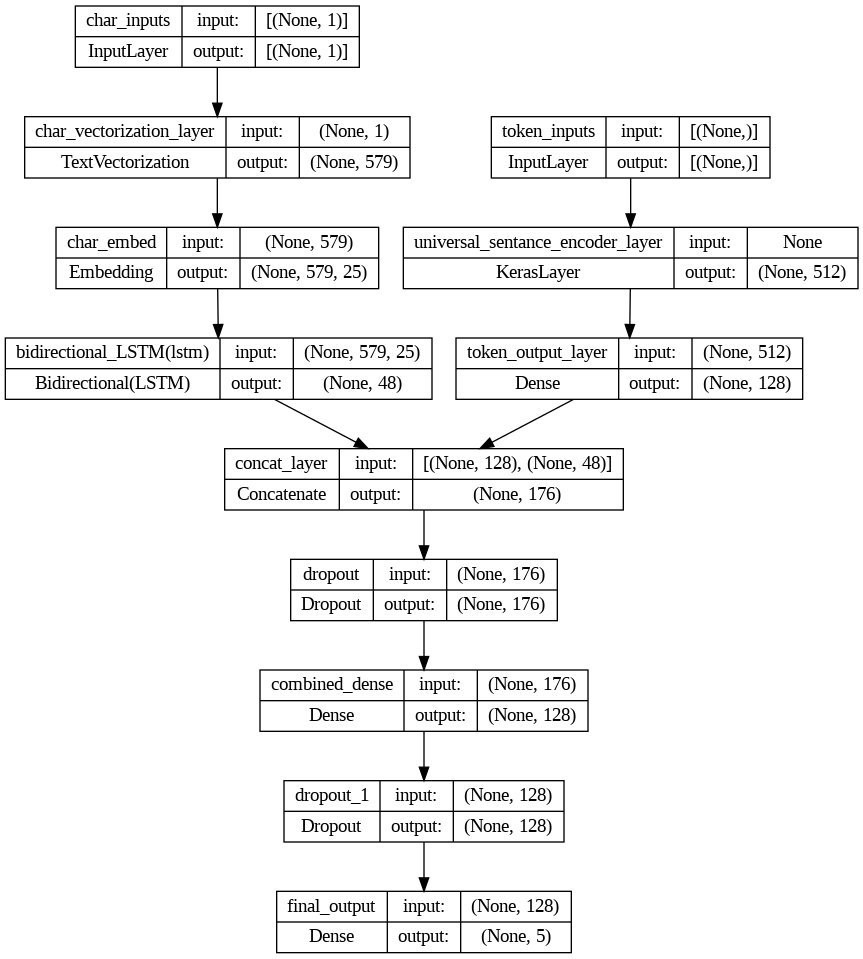

In [95]:
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [96]:
# lets compile the model

model_4.compile(loss = 'categorical_crossentropy',
                optimizer = Adam(),
                metrics = ['accuracy'])

> Lets create the datset for fitting the model as there a tuple of two inputs and to be provoded for the two input different models

In [97]:
# lets create the train-dataset

# 1.create a tuple of both train-inputs in tf.data.Dataset format

# 2.create the one-hot encoded version of the traing labels in tf.data.Dataset format

# 3.zip the aboe dataset using the tf.data.Dataset.zip 

train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentances,train_char)) 
train_token_char_label = tf.data.Dataset.from_tensor_slices(train_target_onehot_encoded) 
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data,train_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)
train_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [98]:
# repeating the same steps for the validation as well as the test dataset

val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentances,val_char)) 
val_token_char_label = tf.data.Dataset.from_tensor_slices(val_target_onehot_encoded) 
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data,val_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)


test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentances,test_char)) 
test_token_char_label = tf.data.Dataset.from_tensor_slices(test_target_onehot_encoded) 
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data,test_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

> Lets fit the model on th 10% of the training batch for quick fitting as we experimenting

In [99]:
history_4 = model_4.fit(train_token_char_dataset,
                        epochs = 5,
                        steps_per_epoch = int(0.1*len(train_token_char_dataset)),
                        validation_data = val_token_char_dataset,
                        validation_steps = int(0.1*len(val_token_char_dataset)))

Epoch 1/5
562/562 [==============================] - 67s 83ms/step - loss: 0.9860 - accuracy: 0.6046 - val_loss: 0.7872 - val_accuracy: 0.7028
Epoch 2/5
562/562 [==============================] - 46s 82ms/step - loss: 0.8058 - accuracy: 0.6873 - val_loss: 0.7257 - val_accuracy: 0.7241
Epoch 3/5
562/562 [==============================] - 41s 73ms/step - loss: 0.7794 - accuracy: 0.7032 - val_loss: 0.7002 - val_accuracy: 0.7350
Epoch 4/5
562/562 [==============================] - 51s 92ms/step - loss: 0.7462 - accuracy: 0.7210 - val_loss: 0.6737 - val_accuracy: 0.7453
Epoch 5/5
562/562 [==============================] - 34s 60ms/step - loss: 0.7516 - accuracy: 0.7166 - val_loss: 0.6603 - val_accuracy: 0.7430


In [100]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 20s 22ms/step - loss: 0.6683 - accuracy: 0.7443


[0.6682502627372742, 0.7443400025367737]

In [101]:
pred_4_probs = model_4.predict(val_token_char_dataset)

pred_4_probs[:10]

945/945 [==============================] - 23s 21ms/step


array([[5.9751999e-01, 2.1640603e-01, 4.7741053e-03, 1.7403042e-01,
        7.2694500e-03],
       [4.7532144e-01, 3.7561429e-01, 8.1172865e-03, 1.3816875e-01,
        2.7781522e-03],
       [3.5683292e-01, 8.4742315e-02, 9.1542259e-02, 4.2485672e-01,
        4.2025812e-02],
       [1.2722787e-02, 1.1146524e-02, 9.1345114e-01, 4.5756479e-03,
        5.8103908e-02],
       [1.0766767e-02, 1.8947260e-02, 8.3096677e-01, 4.7453283e-03,
        1.3457392e-01],
       [1.4787057e-04, 5.3093449e-04, 8.3531350e-01, 5.4783173e-05,
        1.6395293e-01],
       [9.2830230e-04, 4.7578388e-03, 6.4475489e-01, 3.1222016e-04,
        3.4924671e-01],
       [1.4723445e-03, 5.8998256e-03, 6.0406667e-01, 3.9329130e-04,
        3.8816780e-01],
       [4.7295069e-04, 1.5083782e-02, 2.9216101e-02, 2.3898520e-04,
        9.5498824e-01],
       [2.9503590e-01, 3.1440094e-01, 9.0553969e-02, 1.6043429e-01,
        1.3957490e-01]], dtype=float32)

In [102]:
pred_4 = np.argmax(pred_4_probs, axis = 1)
pred_4[:10]

array([0, 0, 3, 2, 2, 2, 2, 2, 4, 1])

In [103]:
results_4 = calculate_results(y_true = val_target_label_encoded,
                              y_pred = pred_4)

results_4

{'accuracy': 0.7443399973520456,
 'precision': 0.7415827979303935,
 'recall': 0.7443399973520456,
 'f1': 0.7388666773965112}

# Model 5 : Token Embedding + Character Embedding + Positional Embedding

Steps:

1. Onehot encod the linenumber label
2. Obehot encod the total lines

3. create an embedding model for tokens
4. create an embedding model for charctors
5. create an embedding model for line number
6. create an embedding model for total number of lines in the abstract
7. combine the outputs of the token embedding and charactor embedding
8. pass the combined layer through a dense layer
9. Dropout 50% of the learned weights to reduce the overfitting
10. combine the outputs of the line number embedding, total line embedding and the dropout layers together
11. create a dense layer
12. create the final model compiling the inputs and the outputs
13. compile the model with label_smoothing = 0.2 to control the overfitting
14. create the tf.data.Datset in the order of the inputs with .zip method
15. train the model 
16. Evaluate the model

> 1.Lets one hot encod the line number

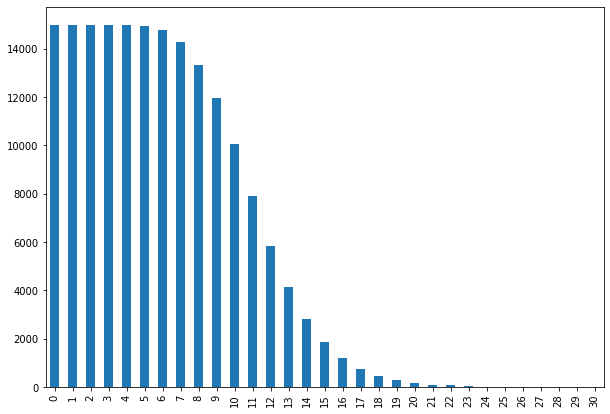

In [109]:
train_df['line_number'].value_counts().plot(kind = 'bar', figsize = (10,7));

In [113]:
np.max(train_df['line_number']), np.mean(train_df['line_number']), np.percentile(train_df['line_number'],98)

(30, 5.894567873805821, 15.0)

In [114]:
optimum_number_lines = int(np.percentile(train_df['line_number'],98))
optimum_number_lines

15

In [135]:
train_line_number_onehot = tf.one_hot(train_df['line_number'].to_numpy(),depth = optimum_number_lines)
train_line_number_onehot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [134]:
val_line_number_onehot = tf.one_hot(val_df['line_number'].to_numpy(),depth = optimum_number_lines)
test_line_number_onehot = tf.one_hot(test_df['line_number'].to_numpy(),depth = optimum_number_lines)

> 2.Lets onehot encode the total numbers of lines in a abstract

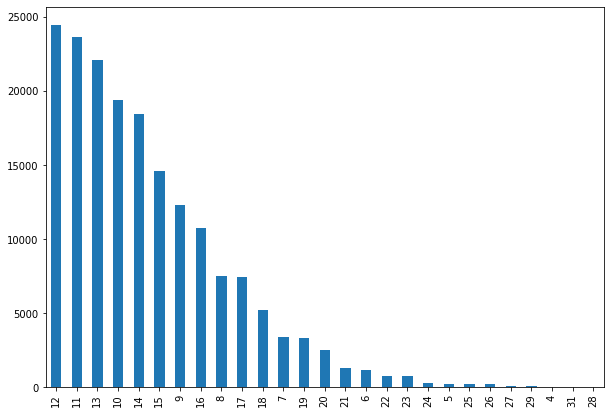

In [121]:
train_df['total_lines'].value_counts().plot(kind='bar', figsize = (10,7));

In [125]:
train_df['total_lines'].value_counts(normalize = True)

12    0.135903
11    0.131299
13    0.122823
10    0.107754
14    0.102411
15    0.081149
9     0.068235
16    0.059809
8     0.041457
17    0.041263
18    0.028894
7     0.018624
19    0.018574
20    0.013775
21    0.007115
6     0.006365
22    0.004277
23    0.004216
24    0.001466
5     0.001194
25    0.001111
26    0.001011
27    0.000450
29    0.000322
4     0.000178
31    0.000172
28    0.000156
Name: total_lines, dtype: float64

In [127]:
cum_sum_distribution = np.cumsum(train_df['total_lines'].value_counts(normalize = True))
cum_sum_distribution

12    0.135903
11    0.267202
13    0.390024
10    0.497778
14    0.600189
15    0.681337
9     0.749572
16    0.809381
8     0.850839
17    0.892102
18    0.920995
7     0.939619
19    0.958193
20    0.971967
21    0.979082
6     0.985448
22    0.989725
23    0.993940
24    0.995407
5     0.996601
25    0.997712
26    0.998723
27    0.999172
29    0.999495
4     0.999672
31    0.999844
28    1.000000
Name: total_lines, dtype: float64

In [130]:
optimum_total_lines = sum(cum_sum_distribution <= 0.98)
optimum_total_lines

15

In [131]:
train_total_lines_onehot = tf.one_hot(train_df['total_lines'], depth = optimum_total_lines)
val_total_lines_onehot = tf.one_hot(val_df['total_lines'], depth = optimum_total_lines)
test_total_lines_onehot = tf.one_hot(test_df['total_lines'], depth = optimum_total_lines)

> Build the model

In [146]:
line_number_shape = tuple(train_line_number_onehot[0].shape)
line_number_shape

(15,)

In [147]:
total_lines_shape = tuple(train_total_lines_onehot[0].shape)
total_lines_shape

(15,)

In [159]:
# lets build the token level embedding model

token_inputs = tf.keras.Input(shape =[], dtype = tf.string, name = 'token_input')
use_embed = token_use_embedding(token_inputs)
token_outputs = layers.Dense(units = 128, activation = 'relu', name = 'token_dense')(use_embed)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs,
                             name = 'token_model')

# lets build the charactor level embedding model

char_inputs = tf.keras.Input(shape = (1,), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vectors)
bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = bi_lstm,
                            name = 'char_model')

# lets build a embedding for line numbers

line_number_inputs = tf.keras.Input(shape = line_number_shape, dtype = tf.float32, name = 'line_numeber_input')
x = layers.Dense(units = 32, activation = 'relu', name = 'line_number_dense')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x, 
                                   name = 'line_number_model')

# lets build a embedding for total lines

total_lines_inputs = tf.keras.Input(shape = total_lines_shape, dtype = tf.float32, name = 'total_lines_input')
y = layers.Dense(units = 32, activation = 'relu', name = 'total_lines_dense')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = y,
                                   name = 'total_lines_model')

# concatenate the token embedding model and the char embedding model

token_char_concat = layers.Concatenate(name = 'token_char_concat')([token_model.output,
                                                                    char_model.output])

# create a dense layer and dropout layer

token_char_dense = layers.Dense(units = 256, activation = 'relu', name = 'token_char_dense')(token_char_concat)

token_char_dropout = layers.Dropout(0.5)(token_char_dense)

# Lets concatenate the line number embedding and the total lines embeddings

all_combine = layers.Concatenate(name = 'all_combine')([line_number_model.output,
                                                        total_lines_model.output,
                                                        token_char_dropout])

all_outputs = layers.Dense(units = num_classes, activation = 'softmax', name = 'all_ouputs')(all_combine)

model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         
                         outputs = all_outputs,
                         
                         name = 'model_5_token_char_pos_embedding')

In [160]:
model_5.summary()

Model: "model_5_token_char_pos_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorization_layer (Text  (None, 579)         0           ['char_input[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 universal_sentance_encoder_lay  (None, 512)         256797824   ['

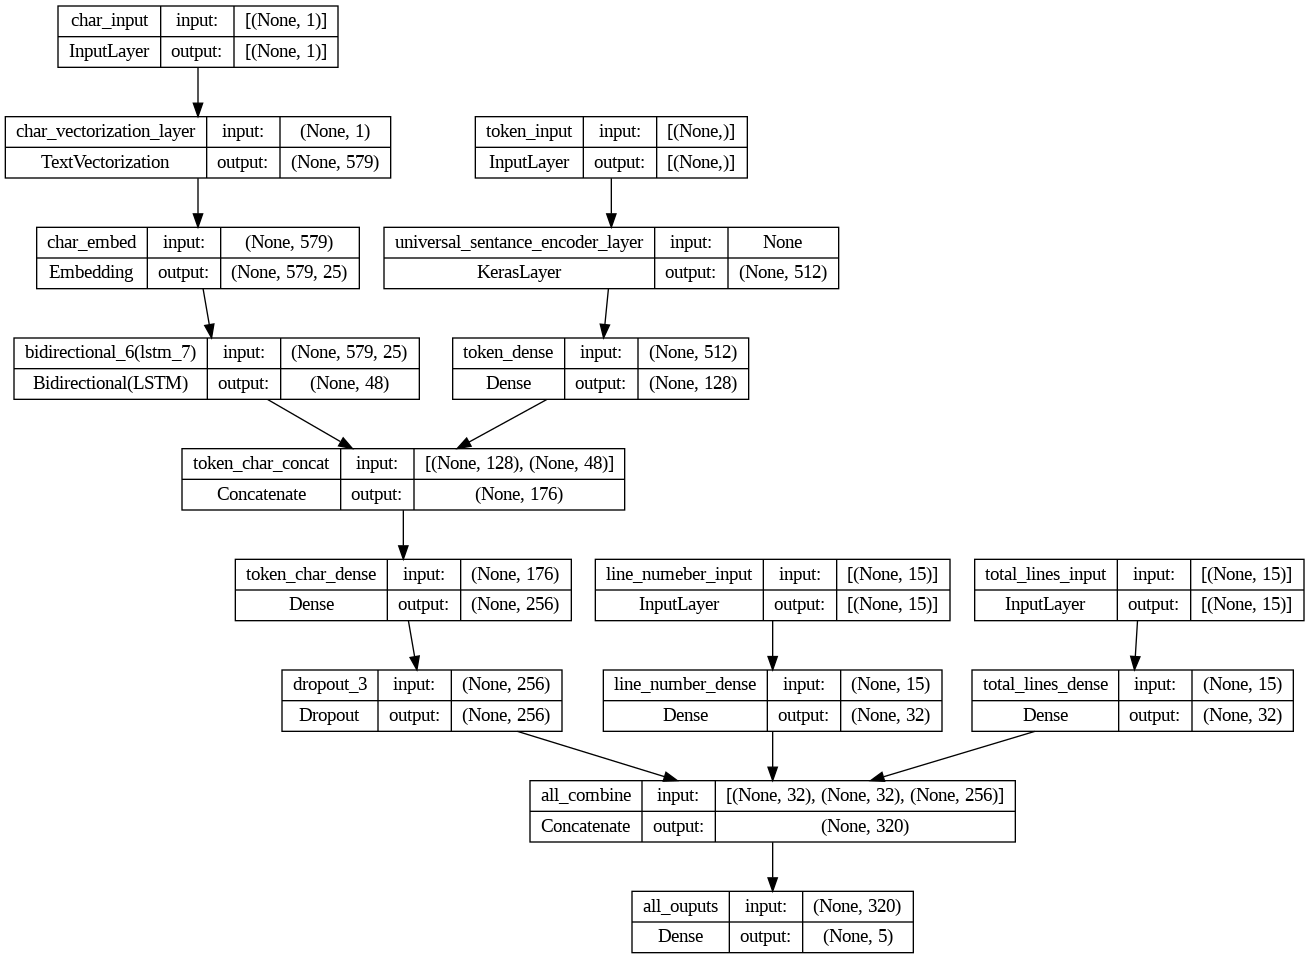

In [162]:
plot_model(model_5, show_shapes = True)

> lets compile the model

In [164]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), # for regularizing the prediction probabilities
                optimizer = Adam(),
                metrics = ['accuracy'])

> Lers make the dataset ready for the the fitting

In [167]:
train_token_char_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_onehot,
                                                                train_total_lines_onehot,
                                                                train_sentances,
                                                                train_char))
train_token_char_pos_label = tf.data.Dataset.from_tensor_slices(train_target_onehot_encoded)

train_token_char_pos_dataset = tf.data.Dataset.zip((train_token_char_pos_data,train_token_char_pos_label)).batch(32).prefetch(tf.data.AUTOTUNE)
train_token_char_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [168]:
# repate the same step for val_dataset

val_token_char_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_onehot,
                                                                val_total_lines_onehot,
                                                                val_sentances,
                                                                val_char))
val_token_char_pos_label = tf.data.Dataset.from_tensor_slices(val_target_onehot_encoded)

val_token_char_pos_dataset = tf.data.Dataset.zip((val_token_char_pos_data,val_token_char_pos_label)).batch(32).prefetch(tf.data.AUTOTUNE)

# repate the same step for test_dataset

test_token_char_pos_data = tf.data.Dataset.from_tensor_slices((test_line_number_onehot,
                                                                test_total_lines_onehot,
                                                                test_sentances,
                                                                test_char))
test_token_char_pos_label = tf.data.Dataset.from_tensor_slices(test_target_onehot_encoded)

test_token_char_pos_dataset = tf.data.Dataset.zip((test_token_char_pos_data,test_token_char_pos_label)).batch(32).prefetch(tf.data.AUTOTUNE)

> Lets fit the model on 10% of the batche of the training data

In [170]:
history_5 = model_5.fit(train_token_char_pos_dataset,
                        epochs = 5,
                        steps_per_epoch = int(0.1*len(train_token_char_pos_dataset)),
                        validation_data = val_token_char_pos_dataset,
                        validation_steps = int(0.1*len(val_token_char_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 51s 68ms/step - loss: 1.0919 - accuracy: 0.7229 - val_loss: 0.9828 - val_accuracy: 0.8055
Epoch 2/5
562/562 [==============================] - 46s 81ms/step - loss: 0.9662 - accuracy: 0.8134 - val_loss: 0.9500 - val_accuracy: 0.8295
Epoch 3/5
562/562 [==============================] - 29s 52ms/step - loss: 0.9499 - accuracy: 0.8212 - val_loss: 0.9377 - val_accuracy: 0.8348
Epoch 4/5
562/562 [==============================] - 40s 71ms/step - loss: 0.9401 - accuracy: 0.8342 - val_loss: 0.9297 - val_accuracy: 0.8358
Epoch 5/5
562/562 [==============================] - 51s 90ms/step - loss: 0.9365 - accuracy: 0.8381 - val_loss: 0.9239 - val_accuracy: 0.8434


In [171]:
model_5.evaluate(val_token_char_pos_dataset)

945/945 [==============================] - 26s 28ms/step - loss: 0.9222 - accuracy: 0.8411


[0.9221623539924622, 0.8410565257072449]

In [172]:
pred_5_probs = model_5.predict(val_token_char_pos_dataset)
pred_5_probs[:10]

945/945 [==============================] - 38s 36ms/step


array([[0.6130208 , 0.07929315, 0.01571607, 0.26871198, 0.023258  ],
       [0.6212767 , 0.09304015, 0.06461056, 0.20814696, 0.01292569],
       [0.36491102, 0.09532963, 0.1413705 , 0.35311198, 0.04527682],
       [0.02460172, 0.07113993, 0.7992472 , 0.02479114, 0.08021998],
       [0.03393375, 0.0259959 , 0.84570396, 0.02993377, 0.0644326 ],
       [0.00953731, 0.0486827 , 0.42431948, 0.01772204, 0.49973848],
       [0.01325306, 0.05998124, 0.25112405, 0.02190585, 0.65373576],
       [0.01185449, 0.09496871, 0.25007448, 0.01994007, 0.62316227],
       [0.01854061, 0.08824344, 0.04254381, 0.02647698, 0.82419515],
       [0.03347579, 0.62881136, 0.07035667, 0.0338515 , 0.23350471]],
      dtype=float32)

In [173]:
pred_5 = np.argmax(pred_5_probs, axis = 1)
pred_5[:10]

array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1])

In [179]:
result_5 = calculate_results(y_true = val_target_label_encoded,
                             y_pred = pred_5)
result_5

{'accuracy': 0.8410565338276181,
 'precision': 0.8437850506191262,
 'recall': 0.8410565338276181,
 'f1': 0.8370021263482866}

# Lets compare all the models tried till now

In [181]:
all_results = pd.DataFrame({'base_model':result_0,
                            model_1.name:result_1,
                            model_2.name:result_2,
                            model_3.name:results_3,
                            model_4.name:results_4,
                            model_5.name:result_5})

all_results = all_results.transpose()
all_results

,accuracy,precision,recall,f1
base_model,0.721832,0.718647,0.721832,0.698925
model_1,0.800311,0.801143,0.800311,0.797211
model_2,0.735701,0.732085,0.735701,0.729824
model_3_conv1D_char_embedding,0.468721,0.420834,0.468721,0.420979
model_4_token_char_embedding_comboined,0.744340,0.741583,0.744340,0.738867
model_5_token_char_pos_embedding,0.841057,0.843785,0.841057,0.837002


In [182]:
all_results.sort_values(by = 'f1', ascending = False, inplace = True)
all_results

,accuracy,precision,recall,f1
model_5_token_char_pos_embedding,0.841057,0.843785,0.841057,0.837002
model_1,0.800311,0.801143,0.800311,0.797211
model_4_token_char_embedding_comboined,0.744340,0.741583,0.744340,0.738867
model_2,0.735701,0.732085,0.735701,0.729824
base_model,0.721832,0.718647,0.721832,0.698925
model_3_conv1D_char_embedding,0.468721,0.420834,0.468721,0.420979


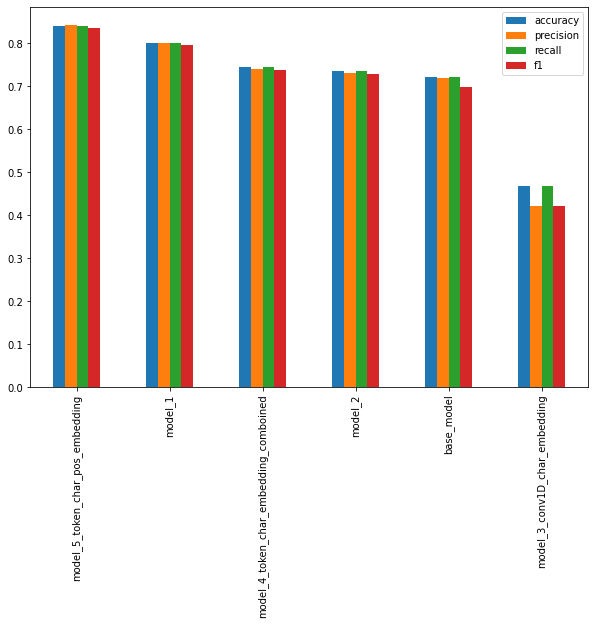

In [184]:
all_results.plot(kind = 'bar', figsize =(10,7)).legend();

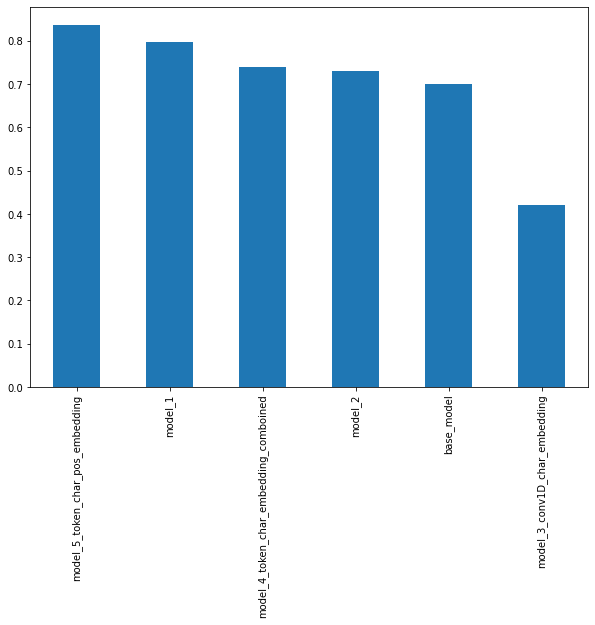

In [186]:
all_results['f1'].plot(kind = 'bar', figsize =(10,7));

Inference : Model 5 is came out to be the best on traing the with 10% batches in the train dataset,,.....


### Lets train the same model in full 20K dataset and see that the model improvinng its perfromance

> Lets Make an exact model like model 5

In [196]:
# lets build the token level embedding model

token_inputs = tf.keras.Input(shape =[], dtype = tf.string, name = 'token_input')
use_embed = token_use_embedding(token_inputs)
token_outputs = layers.Dense(units = 128, activation = 'relu', name = 'token_dense')(use_embed)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs,
                             name = 'token_model')

# lets build the charactor level embedding model

char_inputs = tf.keras.Input(shape = (1,), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vectors)
bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = bi_lstm,
                            name = 'char_model')

# lets build a embedding for line numbers

line_number_inputs = tf.keras.Input(shape = line_number_shape, dtype = tf.float32, name = 'line_numeber_input')
x = layers.Dense(units = 32, activation = 'relu', name = 'line_number_dense')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x, 
                                   name = 'line_number_model')

# lets build a embedding for total lines

total_lines_inputs = tf.keras.Input(shape = total_lines_shape, dtype = tf.float32, name = 'total_lines_input')
y = layers.Dense(units = 32, activation = 'relu', name = 'total_lines_dense')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = y,
                                   name = 'total_lines_model')

# concatenate the token embedding model and the char embedding model

token_char_concat = layers.Concatenate(name = 'token_char_concat')([token_model.output,
                                                                    char_model.output])

# create a dense layer and dropout layer

token_char_dense = layers.Dense(units = 256, activation = 'relu', name = 'token_char_dense')(token_char_concat)

token_char_dropout = layers.Dropout(0.5)(token_char_dense)

# Lets concatenate the line number embedding and the total lines embeddings

all_combine = layers.Concatenate(name = 'all_combine')([line_number_model.output,
                                                        total_lines_model.output,
                                                        token_char_dropout])

all_outputs = layers.Dense(units = num_classes, activation = 'softmax', name = 'all_ouputs')(all_combine)

model_6 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         
                         outputs = all_outputs,
                         
                         name = 'model_6_token_char_pos_embedding')

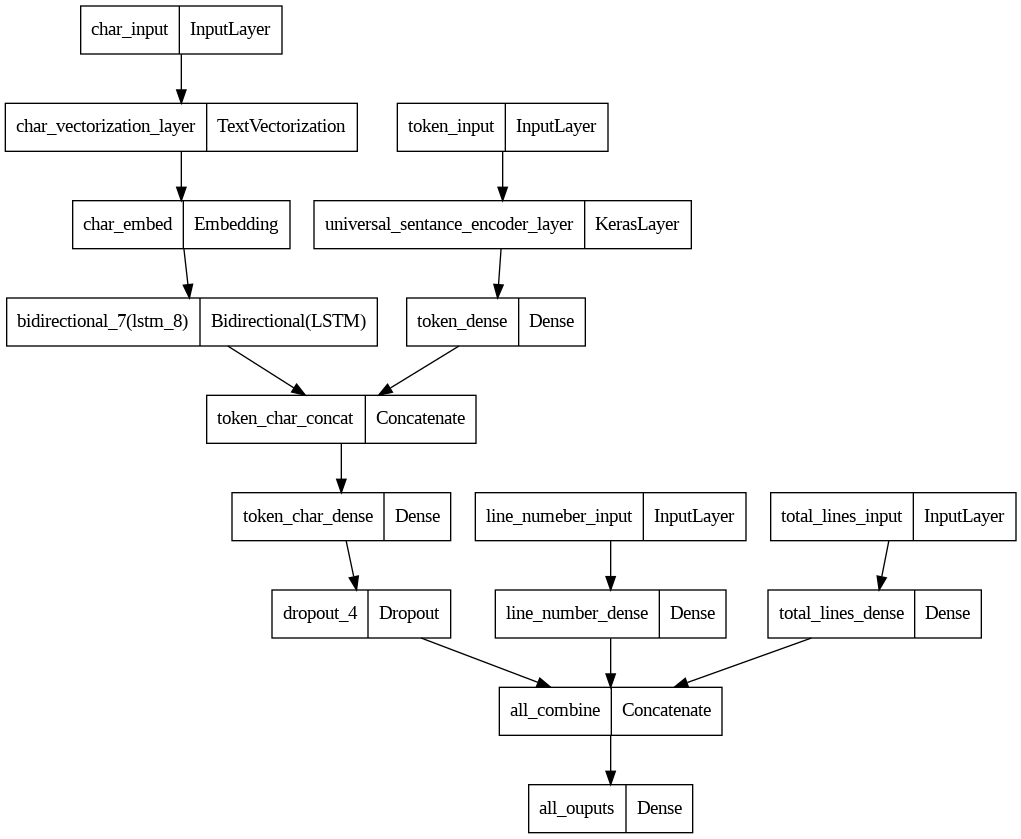

In [197]:
plot_model(model_6)

In [199]:
model_6.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = Adam(),
                metrics = ['accuracy'])

In [200]:
history_6 = model_6.fit(train_token_char_pos_dataset,
                        epochs = 5,
                        steps_per_epoch = len(train_token_char_pos_dataset),
                        validation_data = val_token_char_pos_dataset,
                        validation_steps = int(0.1*len(val_token_char_pos_dataset)))

Epoch 1/5
5627/5627 [==============================] - 362s 62ms/step - loss: 0.9514 - accuracy: 0.8246 - val_loss: 0.9134 - val_accuracy: 0.8464
Epoch 2/5
5627/5627 [==============================] - 344s 61ms/step - loss: 0.9091 - accuracy: 0.8545 - val_loss: 0.9082 - val_accuracy: 0.8491
Epoch 3/5
5627/5627 [==============================] - 348s 62ms/step - loss: 0.8966 - accuracy: 0.8629 - val_loss: 0.9060 - val_accuracy: 0.8507
Epoch 4/5
5627/5627 [==============================] - 345s 61ms/step - loss: 0.8884 - accuracy: 0.8686 - val_loss: 0.9036 - val_accuracy: 0.8504
Epoch 5/5
5627/5627 [==============================] - 340s 60ms/step - loss: 0.8815 - accuracy: 0.8738 - val_loss: 0.9053 - val_accuracy: 0.8501


In [201]:
model_6.evaluate(val_token_char_pos_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.8995 - accuracy: 0.8517


[0.8994901776313782, 0.8517476320266724]

In [202]:
pred_6_probs = model_6.predict(val_token_char_pos_dataset)
pred_6_probs[:10]

945/945 [==============================] - 25s 23ms/step


array([[0.60572916, 0.08356808, 0.02070851, 0.2647101 , 0.02528421],
       [0.59494233, 0.11577459, 0.04623524, 0.22134826, 0.02169956],
       [0.37736055, 0.09600507, 0.06260194, 0.41319308, 0.0508394 ],
       [0.04818821, 0.11468247, 0.65206766, 0.0456495 , 0.13941212],
       [0.04903018, 0.03777999, 0.69273823, 0.0445792 , 0.17587234],
       [0.014561  , 0.03445077, 0.08352556, 0.02548559, 0.84197706],
       [0.01671684, 0.06364068, 0.183857  , 0.02958339, 0.7062021 ],
       [0.02122487, 0.14105687, 0.20845403, 0.03625827, 0.59300596],
       [0.01463596, 0.04152701, 0.01676759, 0.02323477, 0.9038347 ],
       [0.03333876, 0.7728926 , 0.0615031 , 0.02373829, 0.1085273 ]],
      dtype=float32)

In [203]:
pred_6 = np.argmax(pred_6_probs, axis = 1)
pred_6[:10]

array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])

In [204]:
result_6 = calculate_results(y_true = val_target_label_encoded,
                             y_pred = pred_6)
result_6

{'accuracy': 0.8517476499404211,
 'precision': 0.8543193628707373,
 'recall': 0.8517476499404211,
 'f1': 0.8488695284845782}

In [205]:
all_results = pd.DataFrame({'base_model':result_0,
                            model_1.name:result_1,
                            model_2.name:result_2,
                            model_3.name:results_3,
                            model_4.name:results_4,
                            model_5.name:result_5,
                            model_6.name+'v2':result_6})

all_results = all_results.transpose()
all_results.sort_values(by = 'f1', ascending = False, inplace = True)
all_results

,accuracy,precision,recall,f1
model_5_token_char_pos_embeddingv2,0.851748,0.854319,0.851748,0.848870
model_5_token_char_pos_embedding,0.841057,0.843785,0.841057,0.837002
model_1,0.800311,0.801143,0.800311,0.797211
model_4_token_char_embedding_comboined,0.744340,0.741583,0.744340,0.738867
model_2,0.735701,0.732085,0.735701,0.729824
base_model,0.721832,0.718647,0.721832,0.698925
model_3_conv1D_char_embedding,0.468721,0.420834,0.468721,0.420979


# Model 7 : : lets modify the model 6 with conv1D by replacing the bi-LSTM

lets include moedel 1 in model 6 by replacing in the LSTM with conv1D

In [206]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorizer (TextVector  (None, 55)               0         
 ization)                                                        
                                                                 
 embedding_layer (Embedding)  (None, 55, 128)          8704000   
                                                                 
 conv1_layer (Conv1D)        (None, 55, 64)            41024     
                                                                 
 global_avg_pooling (GlobalA  (None, 64)               0         
 veragePooling1D)                                                
                                                                 
 output_layer (Dense)        (None, 5)                 325 

In [215]:
# lets build the token level embedding model

token_inputs = tf.keras.Input(shape =[], dtype = tf.string, name = 'token_input')
use_embed = token_use_embedding(token_inputs)
token_outputs = layers.Dense(units = 128, activation = 'relu', name = 'token_dense')(use_embed)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs,
                             name = 'token_model')

# lets build the charactor level embedding model

char_inputs = tf.keras.Input(shape = (1,), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vectors)
conv_layer = layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu', name = 'conv1_layer')(char_embed)
pooling_layer = layers.GlobalAveragePooling1D(name = 'global_avg_pooling')(conv_layer)
char_outputs = layers.Dense(units = num_classes, activation = 'softmax', name = 'output_layer')(pooling_layer)

char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_outputs,
                            name = 'char_model')

# lets build a embedding for line numbers

line_number_inputs = tf.keras.Input(shape = line_number_shape, dtype = tf.float32, name = 'line_numeber_input')
x = layers.Dense(units = 32, activation = 'relu', name = 'line_number_dense')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x, 
                                   name = 'line_number_model')

# lets build a embedding for total lines

total_lines_inputs = tf.keras.Input(shape = total_lines_shape, dtype = tf.float32, name = 'total_lines_input')
y = layers.Dense(units = 32, activation = 'relu', name = 'total_lines_dense')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = y,
                                   name = 'total_lines_model')

# concatenate the token embedding model and the char embedding model

token_char_concat = layers.Concatenate(name = 'token_char_concat')([token_model.output,
                                                                    char_model.output])

# create a dense layer and dropout layer

token_char_dense = layers.Dense(units = 256, activation = 'relu', name = 'token_char_dense')(token_char_concat)

token_char_dropout = layers.Dropout(0.5)(token_char_dense)

# Lets concatenate the line number embedding and the total lines embeddings

all_combine = layers.Concatenate(name = 'all_combine')([line_number_model.output,
                                                        total_lines_model.output,
                                                        token_char_dropout])

all_outputs = layers.Dense(units = num_classes, activation = 'softmax', name = 'all_ouputs')(all_combine)

model_7 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         
                         outputs = all_outputs,
                         
                         name = 'model_7_token_char_pos_embedding_modified')

In [208]:
model_7.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = Adam(),
                metrics = ['accuracy'])

> Fit the model

In [209]:
history_7 = model_7.fit(train_token_char_pos_dataset,
                        epochs = 5,
                        steps_per_epoch = len(train_token_char_pos_dataset),
                        validation_data = val_token_char_pos_dataset,
                        validation_steps = int(0.1*len(val_token_char_pos_dataset)))

Epoch 1/5
5627/5627 [==============================] - 98s 17ms/step - loss: 0.9577 - accuracy: 0.8188 - val_loss: 0.9217 - val_accuracy: 0.8374
Epoch 2/5
5627/5627 [==============================] - 93s 17ms/step - loss: 0.9137 - accuracy: 0.8500 - val_loss: 0.9136 - val_accuracy: 0.8374
Epoch 3/5
5627/5627 [==============================] - 93s 17ms/step - loss: 0.9020 - accuracy: 0.8578 - val_loss: 0.9100 - val_accuracy: 0.8391
Epoch 4/5
5627/5627 [==============================] - 93s 17ms/step - loss: 0.8942 - accuracy: 0.8644 - val_loss: 0.9104 - val_accuracy: 0.8404
Epoch 5/5
5627/5627 [==============================] - 93s 16ms/step - loss: 0.8876 - accuracy: 0.8690 - val_loss: 0.9088 - val_accuracy: 0.8428


In [210]:
pred_7_probs = model_7.predict(val_token_char_pos_dataset)
pred_7_probs[:10]

945/945 [==============================] - 12s 13ms/step


array([[0.60036856, 0.10428412, 0.02435894, 0.24188448, 0.0291039 ],
       [0.59956926, 0.11558644, 0.0332957 , 0.22917435, 0.02237431],
       [0.42088667, 0.11460248, 0.07169277, 0.35674798, 0.03607012],
       [0.03237652, 0.07438307, 0.75346243, 0.03487522, 0.10490281],
       [0.04768769, 0.04713707, 0.6772776 , 0.05099846, 0.17689924],
       [0.0108115 , 0.01859572, 0.04938871, 0.01966189, 0.9015421 ],
       [0.01270699, 0.04333464, 0.11403291, 0.02345052, 0.8064749 ],
       [0.01615831, 0.13875395, 0.29548335, 0.03361532, 0.51598907],
       [0.01561856, 0.05767711, 0.02307139, 0.02516858, 0.87846434],
       [0.01779816, 0.87875396, 0.03352345, 0.01727362, 0.05265077]],
      dtype=float32)

In [211]:
pred_7 = np.argmax(pred_7_probs, axis = 1)
pred_7[:10]

array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1])

In [212]:
result_7 = calculate_results(y_true = val_target_label_encoded,
                             y_pred = pred_7)
result_7

{'accuracy': 0.8484708063021316,
 'precision': 0.8499726505911289,
 'recall': 0.8484708063021316,
 'f1': 0.8454724008672801}

In [213]:
all_results = pd.DataFrame({'base_model':result_0,
                            model_1.name:result_1,
                            model_2.name:result_2,
                            model_3.name:results_3,
                            model_4.name:results_4,
                            model_5.name:result_5,
                            model_6.name+'v2':result_6,
                            model_7.name:result_7})

all_results = all_results.transpose()
all_results.sort_values(by = 'f1', ascending = False, inplace = True)
all_results

,accuracy,precision,recall,f1
model_5_token_char_pos_embeddingv2,0.851748,0.854319,0.851748,0.848870
model_7_token_char_pos_embedding_modified,0.848471,0.849973,0.848471,0.845472
model_5_token_char_pos_embedding,0.841057,0.843785,0.841057,0.837002
model_1,0.800311,0.801143,0.800311,0.797211
model_4_token_char_embedding_comboined,0.744340,0.741583,0.744340,0.738867
model_2,0.735701,0.732085,0.735701,0.729824
base_model,0.721832,0.718647,0.721832,0.698925
model_3_conv1D_char_embedding,0.468721,0.420834,0.468721,0.420979


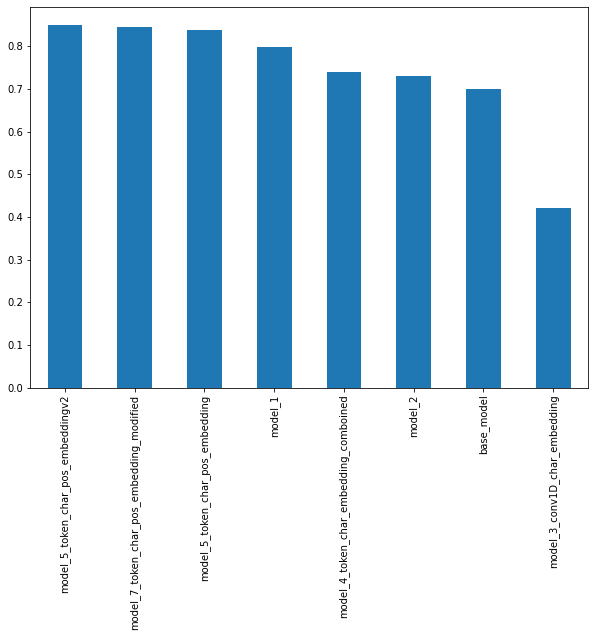

In [255]:
all_results['f1'].plot(kind = 'bar', figsize =(10,7));

Ineference : Model 6 is the best model so far

### Lets save and load the model back in and evaluate

In [216]:
model_6.save('best_model/selected_model')

In [217]:
loaded_model = tf.keras.models.load_model('best_model/selected_model')

In [219]:
loaded_model.evaluate(val_token_char_pos_dataset)

945/945 [==============================] - 25s 23ms/step - loss: 0.9073 - accuracy: 0.8495


[0.9072875380516052, 0.8495299816131592]

In [220]:
model_6.evaluate(val_token_char_pos_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.9073 - accuracy: 0.8495


[0.9072875380516052, 0.8495299816131592]

### Lets understand the most wrong predictions

In [222]:
final_model_pred_probs = loaded_model.predict(val_token_char_pos_dataset)
final_model_pred_probs

945/945 [==============================] - 20s 21ms/step


array([[0.6116094 , 0.08948925, 0.01974239, 0.25501478, 0.02414423],
       [0.6074102 , 0.11624981, 0.04197186, 0.21509878, 0.01926937],
       [0.33118087, 0.09336321, 0.06684965, 0.45889235, 0.04971388],
       ...,
       [0.02149023, 0.05915087, 0.01395128, 0.02723837, 0.87816924],
       [0.01379863, 0.5682716 , 0.07192989, 0.02131235, 0.32468754],
       [0.05048896, 0.9044339 , 0.01333546, 0.0181509 , 0.01359089]],
      dtype=float32)

In [224]:
final_model_confidence = np.max(final_model_pred_probs, axis = 1)
final_model_confidence

array([0.6116094 , 0.6074102 , 0.45889235, ..., 0.87816924, 0.5682716 ,
       0.9044339 ], dtype=float32)

In [225]:
final_model_label = np.argmax(final_model_pred_probs, axis = 1)
final_model_label

array([0, 0, 3, ..., 4, 1, 1])

In [232]:
classes = label_encoder.classes_

final_model_class = [classes[label] for label in final_model_label ]
final_model_class[:10]

['BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS']

> Lets create the prediction dataframe

In [250]:
val_df = pd.DataFrame({'sentance': val_sentances,
              'actual_class': val_target,
              'predcted_class':np.array(final_model_class),
              'actual_label':val_target_label_encoded,
              'predicted_label':final_model_label,
              'prediction_confidence':final_model_confidence})
val_df.head(5)

,sentance,actual_class,predcted_class,actual_label,predicted_label,prediction_confidence
0,ige sensitization to aspergillus fumigatus and...,BACKGROUND,BACKGROUND,0,0,0.611609
1,it is not clear whether these patients would b...,BACKGROUND,BACKGROUND,0,0,0.607410
2,we sought to determine whether a @-month cours...,OBJECTIVE,OBJECTIVE,3,3,0.458892
3,asthmatic patients who were ige sensitized to ...,METHODS,METHODS,2,2,0.498704
4,primary outcomes were improvement in quality o...,METHODS,METHODS,2,2,0.696790


In [252]:
wrong_pred_df = val_df[val_df['actual_label'] != val_df['predicted_label']]
wrong_pred_df.head()

,sentance,actual_class,predcted_class,actual_label,predicted_label,prediction_confidence
13,the present pilot study tested the hypothesis ...,OBJECTIVE,METHODS,3,2,0.332925
16,oral d-amphetamine produced prototypical physi...,RESULTS,CONCLUSIONS,4,1,0.433221
18,naltrexone and alprazolam each significantly a...,RESULTS,CONCLUSIONS,4,1,0.564583
19,the combination attenuated a greater number of...,RESULTS,CONCLUSIONS,4,1,0.453114
24,we tested the impact of conceptual instruction...,OBJECTIVE,BACKGROUND,3,0,0.300981


In [254]:
# top10 wrong predictions with high confidence by the model
wrong_pred_df.sort_values(by = 'prediction_confidence', ascending = False, inplace = True)
wrong_pred_df.head(10)

,sentance,actual_class,predcted_class,actual_label,predicted_label,prediction_confidence
11885,sasa !,CONCLUSIONS,BACKGROUND,1,0,0.963700
7300,to examine the effects of complex cognitive ( ...,BACKGROUND,OBJECTIVE,0,3,0.958665
21580,to evaluate the potential efficacy and safety ...,BACKGROUND,OBJECTIVE,0,3,0.952869
18208,to compare pain response outcomes for patients...,BACKGROUND,OBJECTIVE,0,3,0.942262
25984,to investigate the performance of the mi sxsco...,BACKGROUND,OBJECTIVE,0,3,0.937238
14137,the disease process leading to clinical type @...,OBJECTIVE,BACKGROUND,3,0,0.936808
9053,"nct@ , www.clinicaltrials.gov .",CONCLUSIONS,BACKGROUND,1,0,0.932376
8345,there was one patient who developed a non-fata...,CONCLUSIONS,RESULTS,1,4,0.932068
6709,@ ( @ % ) of the @ eligible patients were enro...,METHODS,RESULTS,2,4,0.928594
22750,"at @months , rates of the composite outcome of...",CONCLUSIONS,RESULTS,1,4,0.924978


### End of the Document